In [2]:
library(argparse)
library(Seurat)
library(harmony)
library(yaml)
library(dplyr)
library(harmony)
packageVersion('harmony')
library(patchwork)
library(tidyverse)
library(rliger)
library(Matrix)
library(Signac)
packageVersion('Signac')
library(ggplot2)

[1] ‘0.1.1’

[1] ‘1.9.0’

In [3]:
results_dir <- "/home/xcx/results/P0/6-Harmony"

counts.rna <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/RNA/matrix.mtx')
rownames(counts.rna) <- paste("Gene-", seq(1, dim(counts.rna)[1]), sep = "")
colnames(counts.rna) <- paste("Cell-", seq(1, dim(counts.rna)[2]), sep = "")
counts.atac <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/ATAC/matrix.mtx')
rownames(counts.atac) <- paste("Region-", seq(1, dim(counts.atac)[1]), sep = "")
colnames(counts.atac) <- paste("Cell-", seq(dim(counts.rna)[2] + 1, dim(counts.rna)[2] + dim(counts.atac)[2]), sep = "")
label.rna <- read.table(file = paste0("/home/xcx/MYBenchmark-datas/P0/cell_label.csv"), sep = "\t", header = TRUE)
label.atac <- read.table(file = paste0("/home/xcx/MYBenchmark-datas/P0/cell_label.csv"), sep = "\t", header = TRUE)

region2gene <- Matrix::readMM('/home/xcx/MYBenchmark-datas/P0/ATAC/region2gene.mtx')
rownames(region2gene) <- paste("Region-", seq(1, dim(region2gene)[1]), sep = "")
colnames(region2gene) <- paste("Gene-", seq(1, dim(region2gene)[2]), sep = "")

In [4]:
start_time <- proc.time()

seurat.atac <- CreateSeuratObject(counts = counts.atac, assay = "ATAC", project = "scATAC-seq")
seurat.atac$tech <- "atac"

seurat.atac <- RunTFIDF(seurat.atac, verbose = FALSE)
seurat.atac <- FindTopFeatures(seurat.atac, min.cutoff = "q0", verbose = FALSE)
seurat.atac <- RunSVD(seurat.atac, verbose = FALSE)
seurat.atac <- RunUMAP(seurat.atac, reduction = "lsi", dims = 2:30, reduction.name = "umap.atac", reduction.key = "atacUMAP_",  verbose = FALSE)

seurat.atac <- FindVariableFeatures(seurat.atac, selection.method = "vst", verbose = FALSE)
seurat.atac <- seurat.atac[VariableFeatures(seurat.atac)]

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [5]:
# create seurat obj of scRNA-Seq
seurat.rna <- CreateSeuratObject(counts=counts.rna, assay = "RNA", project = "scRNA-seq")
seurat.rna$tech <- "rna"

# preprocessing scRNA-Seq data
seurat.rna <- NormalizeData(seurat.rna, verbose = FALSE)
# select highly variable features, use all features for symsim
seurat.rna <- FindVariableFeatures(seurat.rna, selection.method = "vst", verbose = FALSE)
seurat.rna <- ScaleData(seurat.rna, verbose = FALSE)
seurat.rna <- RunPCA(seurat.rna, verbose = FALSE)
seurat.rna <- RunUMAP(seurat.rna, dims = 1:30, verbose = FALSE)

seurat.rna <- seurat.rna[VariableFeatures(seurat.rna)]

In [7]:
rna.so = seurat.rna
atac.so = seurat.atac

rna.so$cell_type <- c(label.rna)
atac.so$cell_type <- c(label.atac)
rna.so$domain <- c(rep("scRNA-seq"))
atac.so$domain <- c(rep("scATAC-seq"))

combined.so <- merge(rna.so, atac.so)
combined.so
head(combined.so)
table(combined.so[[]]$domain)
# combined.so[[]]$orig.ident

An object of class Seurat 
4000 features across 10162 samples within 2 assays 
Active assay: RNA (2000 features, 0 variable features)
 1 other assay present: ATAC

,orig.ident,nCount_RNA,nFeature_RNA,tech,cell_type,domain,nCount_ATAC,nFeature_ATAC
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>
Cell-1,scRNA-seq,56,34,rna,"0,Ex6_Tle4",scRNA-seq,NA,NA
Cell-2,scRNA-seq,47,24,rna,"1,Ex56_Epha6",scRNA-seq,NA,NA
Cell-3,scRNA-seq,40,29,rna,"2,Ex5_Crmp1",scRNA-seq,NA,NA
Cell-4,scRNA-seq,109,64,rna,"3,Ex345_Foxp1",scRNA-seq,NA,NA
Cell-5,scRNA-seq,48,24,rna,"4,Ex6_Tle4",scRNA-seq,NA,NA
Cell-6,scRNA-seq,84,53,rna,"5,Ex345_Foxp1",scRNA-seq,NA,NA
Cell-7,scRNA-seq,99,56,rna,"6,Ex56_Epha6",scRNA-seq,NA,NA
Cell-8,scRNA-seq,195,132,rna,"7,Endo",scRNA-seq,NA,NA
Cell-9,scRNA-seq,31,26,rna,"8,Ex6_Tle4",scRNA-seq,NA,NA



scATAC-seq  scRNA-seq 
      5081       5081 

In [8]:
start_time <- proc.time()
combined.so <- NormalizeData(combined.so)
hvg <- VariableFeatures(seurat.rna)
VariableFeatures(combined.so) <- hvg

combined.so <- ScaleData(combined.so)
# combined.so <- SCTransform(combined.so)
combined.so <- RunPCA(combined.so, npcs = 50, seed.use = 0, verbose = FALSE)
combined.so <- RunUMAP(combined.so, verbose = FALSE, dims=2:30)

Centering and scaling data matrix



In [9]:
png(filename = "/home/xcx/results/P0/6-Harmony/rna_atac.png", width = 1200, height = 900, res = 300)
    
p1 <- DimPlot(seurat.rna, label = TRUE) + NoLegend() + ggtitle("RNA")
p2 <- DimPlot(seurat.atac, label = TRUE) + NoLegend() + ggtitle("ATAC")
p1 + p2

dev.off()

png 
  2

In [10]:
# VariableFeatures(combined.so)
combined.so
head(combined.so[10000:10090,])
combined.so@assays$ATAC

An object of class Seurat 
4000 features across 10162 samples within 2 assays 
Active assay: RNA (2000 features, 2000 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: pca, umap

,orig.ident,nCount_RNA,nFeature_RNA,tech,cell_type,domain,nCount_ATAC,nFeature_ATAC
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>
Cell-1,scRNA-seq,56,34,rna,"0,Ex6_Tle4",scRNA-seq,0,0
Cell-2,scRNA-seq,47,24,rna,"1,Ex56_Epha6",scRNA-seq,0,0
Cell-3,scRNA-seq,40,29,rna,"2,Ex5_Crmp1",scRNA-seq,0,0
Cell-4,scRNA-seq,109,64,rna,"3,Ex345_Foxp1",scRNA-seq,0,0
Cell-5,scRNA-seq,48,24,rna,"4,Ex6_Tle4",scRNA-seq,0,0
Cell-6,scRNA-seq,84,53,rna,"5,Ex345_Foxp1",scRNA-seq,0,0
Cell-7,scRNA-seq,99,56,rna,"6,Ex56_Epha6",scRNA-seq,0,0
Cell-8,scRNA-seq,195,132,rna,"7,Endo",scRNA-seq,0,0
Cell-9,scRNA-seq,31,26,rna,"8,Ex6_Tle4",scRNA-seq,0,0


Assay data with 2000 features for 10162 cells
First 10 features:
 Region-90161, Region-131899, Region-161211, Region-41341,
Region-107230, Region-1644, Region-3530, Region-8197, Region-19754,
Region-21712 

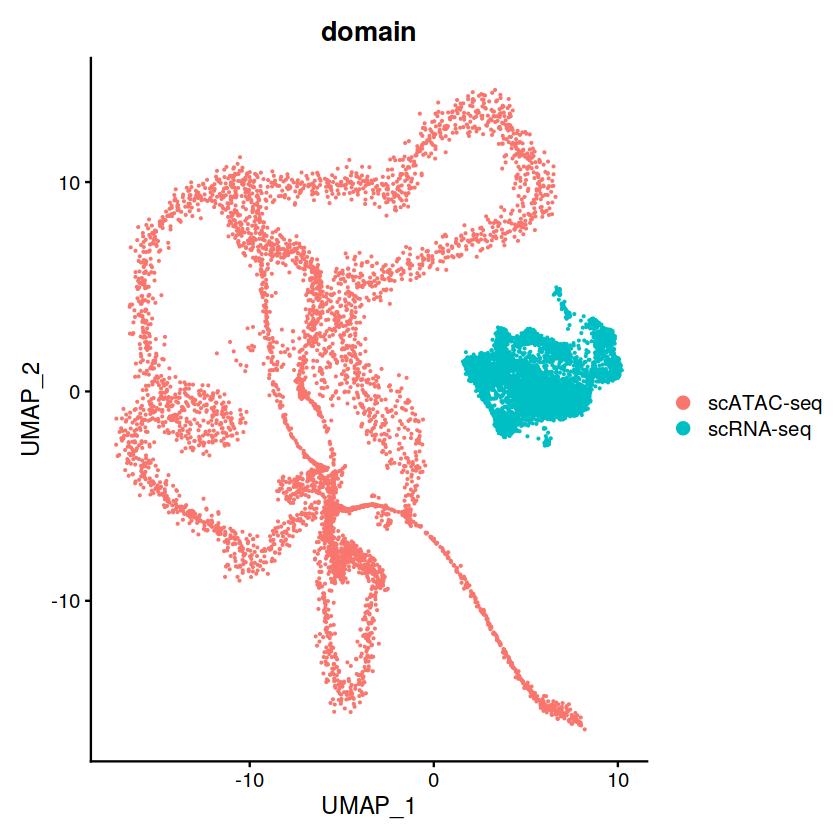

In [11]:
p1 <- DimPlot(object = combined.so, pt.size = .1, group.by = "domain")
p1

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20

Harmony 6/20

Harmony 7/20

Harmony 8/20

Harmony 9/20

Harmony 10/20

Harmony 11/20

Harmony 12/20

Harmony 13/20

Harmony 14/20

Harmony 15/20

Harmony 16/20

Harmony 17/20

Harmony 18/20

Harmony 19/20

Harmony 20/20

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


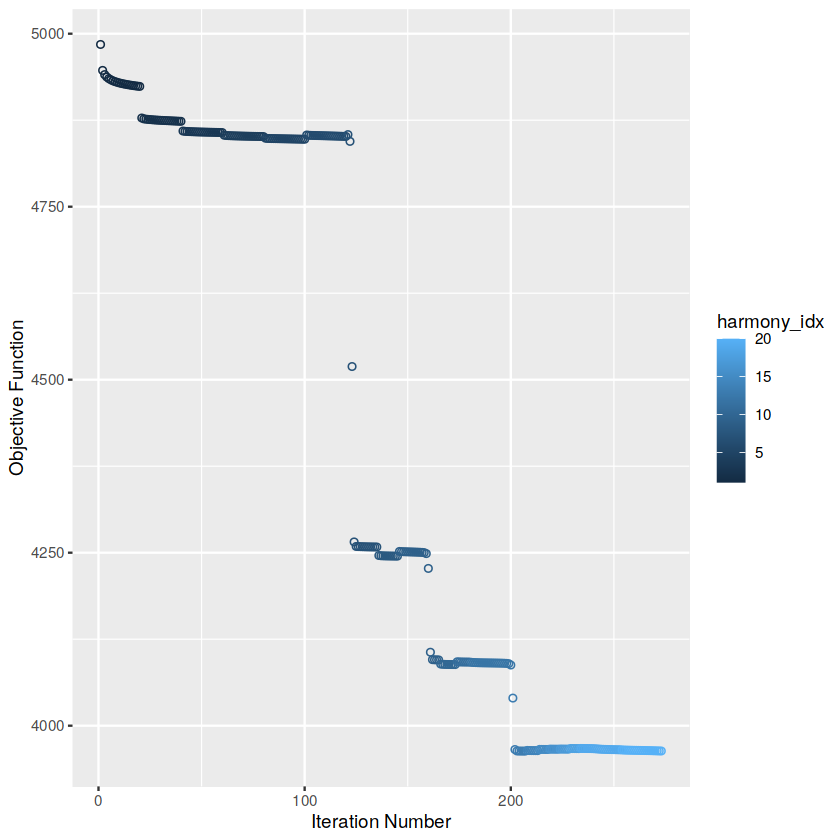

In [12]:
# dim(combined.so)
# combined.so
# head(combined.so)

combined.so_harmony <- RunHarmony(combined.so, plot_convergence = TRUE, group.by.vars = "domain", max.iter.harmony = 20, lambda = 0.1, epsilon.harmony=-Inf)
elapsed_time <- proc.time() - start_time

In [13]:
elapsed_time

    user   system  elapsed 
 540.928 1779.185  459.857 

In [14]:
harmony_embeddings <- Embeddings(combined.so_harmony, reduction='harmony')
# dim(counts.rna)[2]+1
# dim(counts.atac)[2]+dim(counts.rna)[2]
harmony_embeddings[(dim(counts.rna)[2]+1):10162,]

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5,harmony_6,harmony_7,harmony_8,harmony_9,harmony_10,⋯,harmony_41,harmony_42,harmony_43,harmony_44,harmony_45,harmony_46,harmony_47,harmony_48,harmony_49,harmony_50
Cell-5082,2.069231,-0.1425341,0.2236859,0.1137301,0.02094007,0.9481677,-0.7348664,0.3617118,-0.4824243,0.07165872,⋯,-0.04290869,-0.01689964,-0.05969972,-0.01692776,-0.0002457525,-0.04562215,0.03792712,-0.02344732,0.08654813,-0.04116903
Cell-5083,2.069231,-0.1425340,0.2236860,0.1137297,0.02094037,0.9481675,-0.7348664,0.3617117,-0.4824245,0.07165876,⋯,-0.04290873,-0.01689966,-0.05969978,-0.01692777,-0.0002457252,-0.04562211,0.03792707,-0.02344722,0.08654793,-0.04116912
Cell-5084,2.069231,-0.1425341,0.2236859,0.1137301,0.02094005,0.9481677,-0.7348665,0.3617119,-0.4824243,0.07165872,⋯,-0.04290869,-0.01689964,-0.05969972,-0.01692776,-0.0002457518,-0.04562216,0.03792712,-0.02344733,0.08654814,-0.04116902
Cell-5085,2.069231,-0.1425341,0.2236858,0.1137301,0.02094005,0.9481676,-0.7348663,0.3617118,-0.4824243,0.07165871,⋯,-0.04290868,-0.01689963,-0.05969973,-0.01692774,-0.0002457634,-0.04562215,0.03792712,-0.02344733,0.08654813,-0.04116902
Cell-5086,2.069232,-0.1425340,0.2236858,0.1137298,0.02094029,0.9481670,-0.7348660,0.3617116,-0.4824242,0.07165870,⋯,-0.04290869,-0.01689963,-0.05969983,-0.01692772,-0.0002457683,-0.04562209,0.03792711,-0.02344726,0.08654794,-0.04116909
Cell-5087,2.069232,-0.1425340,0.2236859,0.1137296,0.02094041,0.9481669,-0.7348659,0.3617115,-0.4824241,0.07165870,⋯,-0.04290870,-0.01689963,-0.05969986,-0.01692772,-0.0002457696,-0.04562207,0.03792709,-0.02344722,0.08654786,-0.04116913
Cell-5088,2.069231,-0.1425341,0.2236859,0.1137301,0.02094007,0.9481677,-0.7348664,0.3617118,-0.4824243,0.07165872,⋯,-0.04290869,-0.01689964,-0.05969972,-0.01692776,-0.0002457525,-0.04562215,0.03792712,-0.02344732,0.08654813,-0.04116903
Cell-5089,2.069232,-0.1425340,0.2236858,0.1137299,0.02094018,0.9481672,-0.7348661,0.3617117,-0.4824242,0.07165870,⋯,-0.04290868,-0.01689963,-0.05969979,-0.01692773,-0.0002457736,-0.04562211,0.03792712,-0.02344729,0.08654802,-0.04116906
Cell-5090,2.069232,-0.1425340,0.2236859,0.1137299,0.02094021,0.9481673,-0.7348662,0.3617117,-0.4824242,0.07165871,⋯,-0.04290869,-0.01689963,-0.05969980,-0.01692773,-0.0002457640,-0.04562211,0.03792711,-0.02344729,0.08654800,-0.04116907
Cell-5091,2.069232,-0.1425340,0.2236859,0.1137299,0.02094021,0.9481673,-0.7348662,0.3617117,-0.4824242,0.07165871,⋯,-0.04290869,-0.01689963,-0.05969980,-0.01692773,-0.0002457640,-0.04562211,0.03792711,-0.02344729,0.08654800,-0.04116907


In [186]:
# combined.so_harmony
combined.so_harmony@reductions[["harmony"]]

harmony_ 1 
Positive:  Gene-583, Gene-54, Gene-307, Gene-855, Gene-64, Gene-585, Gene-239, Gene-373, Gene-660, Gene-1 
	   Gene-559, Gene-427, Gene-55, Gene-368, Gene-7, Gene-999, Gene-387, Gene-156, Gene-150, Gene-345 
Negative:  Gene-79, Gene-219, Gene-587, Gene-227, Gene-611, Gene-626, Gene-58, Gene-242, Gene-97, Gene-592 
	   Gene-825, Gene-538, Gene-531, Gene-705, Gene-526, Gene-378, Gene-493, Gene-220, Gene-57, Gene-215 
harmony_ 2 
Positive:  Gene-826, Gene-458, Gene-850, Gene-959, Gene-559, Gene-462, Gene-88, Gene-438, Gene-69, Gene-230 
	   Gene-106, Gene-55, Gene-492, Gene-832, Gene-920, Gene-185, Gene-172, Gene-568, Gene-329, Gene-737 
Negative:  Gene-79, Gene-242, Gene-219, Gene-227, Gene-58, Gene-611, Gene-587, Gene-705, Gene-825, Gene-883 
	   Gene-493, Gene-413, Gene-325, Gene-526, Gene-538, Gene-378, Gene-57, Gene-555, Gene-626, Gene-592 
harmony_ 3 
Positive:  Gene-462, Gene-850, Gene-205, Gene-204, Gene-824, Gene-241, Gene-492, Gene-329, Gene-185, Gene-474 
	   Gene-8

In [15]:
# clustering
combined.so_harmony <- FindNeighbors(combined.so_harmony, reduction = "harmony", dims = 1:30) %>% FindClusters(resolution = 0.5)
# umap/tsne
# combined.so_harmony<- RunTSNE(combined.so_harmony, reduction = "harmony", dims = 1:30)
combined.so_harmony <- RunUMAP(combined.so_harmony, reduction = "harmony", dims = 1:30, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10162
Number of edges: 901295

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9717
Number of communities: 22
Elapsed time: 7 seconds


In [16]:
umap_integrated2 <- DimPlot(combined.so_harmony, reduction = "umap", label = TRUE)

umap_tsne_integrated <- CombinePlots(list(umap_integrated1,umap_integrated2),ncol=2)
umap_tsne_integratedss
ggsave("/home/xcx/results/P0/6-Harmony/umap_tsne_integrated.pdf",umap_tsne_integrated,wi=25,he=15)

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


ERROR: Error in eval(expr, envir, enclos): object 'umap_tsne_integratedss' not found


In [18]:
library(data.table)
# data_to_write_out <- as.data.frame(as.matrix(coembed[['RNA']]))
data_to_write_out <- as.data.frame(as.matrix(harmony_embeddings[colnames(rna.so),]))
fwrite(x = data_to_write_out, file = "/home/xcx/results/P0/6-Harmony/z_rna.csv")

data_to_write_out <- as.data.frame(as.matrix(harmony_embeddings[colnames(atac.so),]))
fwrite(x = data_to_write_out, file = "/home/xcx/results/P0/6-Harmony/z_atac.csv")